# <center>Project Proposal: Analysis and Prediction of Flight Delays</center>
#### **Authors:** Longfei Guan, Cheng Zhang, Heidi Lantz, Clare Pan
#### **Group:** 20

## 1. Introduction

In recent years, the air transport industry has grown rapidly. It promotes tourism, generates economic growth, and provides employment opportunities (Air Transport Action Group, 2022). However, there is no denying that flight delays are becoming more frequent. The Federal Aviation Administration (FAA) considers a flight to be delayed if it departs 15 minutes after the scheduled time (Trefis Team, 2016). Delays not only inconvenience passengers but also cost airlines billions of dollars and disrupt airport operations, damaging the airline's reputation (Wang et al., 2019). Because airline industries across the world take up a great part of the global economy, the number of flight delays could have a significant impact on customers’ satisfaction with the airlines. Therefore, it is important to investigate and understand the key factors that can influence flight delays. This project will use the 2015 Flight Delays and Cancellations dataset published by the U.S. Department of Transportation (2017) to investigate the possible variables that are associated with flight delays and make predictions about the average departure time delay based on the conclusion. 

The dataset includes 14 unique airlines from the United States, but for this project, we will select Delta Airlines as our subject. Delta Airlines is currently the second-largest airline in the world in terms of total U.S. passenger miles and passenger fleet size, and it is a founding member of the SkyTeam alliance, which has more than 325 destinations in 52 countries on six continents (Wikipedia, 2022). We suppose the study of Delta Airlines will be representative and generalizable for the US airline population. We will examine thirteen potential factors from a total of 31 variables that influence airline delays. These 13 variables includes `MONTH`, `DAY`, `DAY_OF_WEEK`, `AIRLINE`, `ORIGIN_AIRPORT`, `DESTINATION_AIRPORT`, `SCHEDULED_DEPARTURE`, `DEPARTURE_TIME`, `DEPARTURE_DELAY`, `SCHEDULED_TIME`, `ELAPSED_TIME`, `AIR_TIME`,and `DISTANCE`. After determining which of the 13 factors can affect airplane delay times, we will use these variables to predict delta airline delay time.

- `MONTH`: month of the Flight Trips
- `DAY`: Day of the Flight Trip
- `DAY_OF_WEEK`: Day of week of the Flight Trip
- `AIRLINE`: Airline Identifier (in our dataset, only one airline: DL (Delta Airlines))
- `ORIGIN_AIRPORT`: Starting Airport
- `DESTINATION_AIRPORT`: Destination Airport
- `SCHEDULED_DEPARTUR`: Planned Departure Time
- `DEPARTURE_TIME`: WHEEL_OFF - TAXI_OUT
- `DEPARTURE_DELAY`: Total Delay on Departure
- `SCHEDULED_TIME`: Planned time amount needed for the flight trip
- `ELAPSED_TIME`: AIR_TIME + TAXI_IN + TAXI_OUT
- `AIR_TIME`: The time duration between wheels_off and wheels_on time
- `DISTANCE`: Distance between two airports

## 2. Preliminary Results

### Loading relevant libraries

In [2]:
library (tidyverse)
library (repr)
library (infer)
library (broom)
library (GGally)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### Reading & cleaning the datasets

* Since the origianl dataset is too huge(592.4MB), we have uploaded it on to github and loaded the data by read_csv(). And we removed all the irrelevant variables. 

In [3]:
flight_data <- read_csv("delta_flights.csv")
flight_data <- flight_data[complete.cases(flight_data), ] %>%
  select(-...1,- replicate,-AIRLINE)

New names:
• `` -> `...1`
Rows: 5000 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT
dbl (12): ...1, replicate, MONTH, DAY, DAY_OF_WEEK, SCHEDULED_DEPARTURE, DEP...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


* We begin by checking for the association of the explanatory variables with the response variables. ggparis() could help us visualize it.
* There are too many distinct values in ORIGIN_AIRPORT and DESTINATION_AIRPORT, so we filter out these two categorical variables.

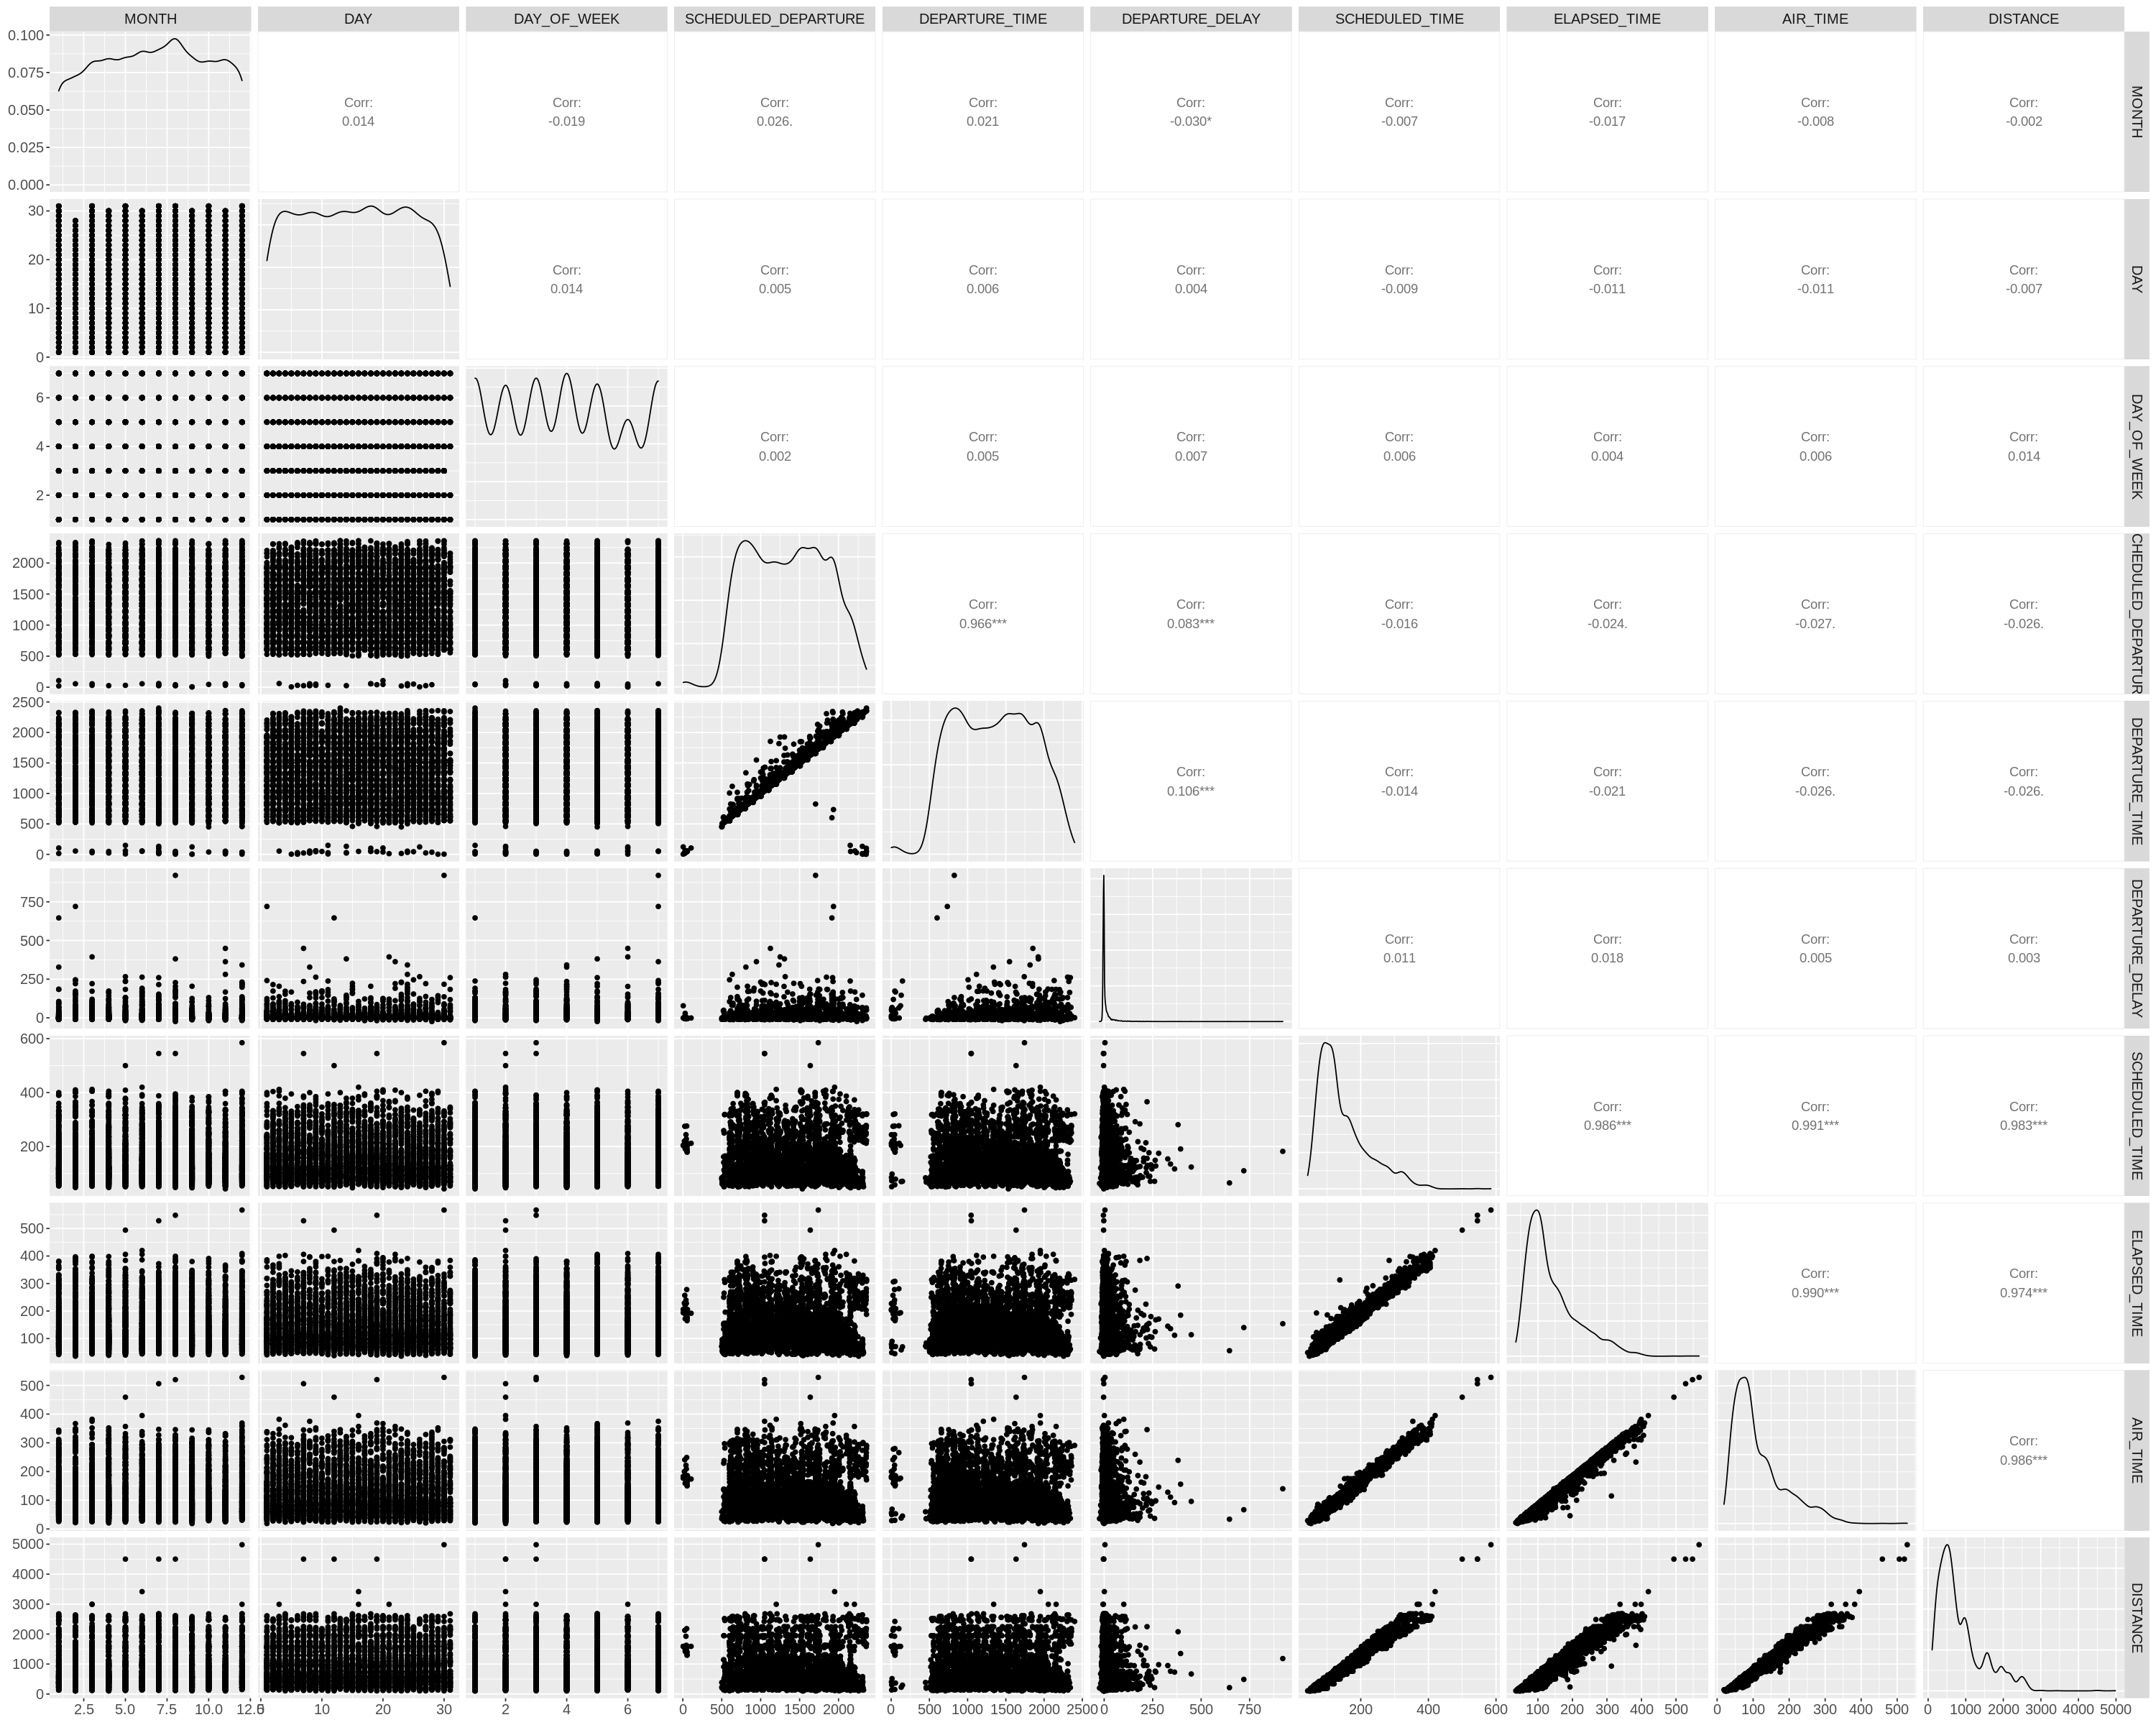

In [4]:
options(repr.plot.width = 25, repr.plot.height = 20)
flight_pair_plots <- flight_data %>%
  select(- ORIGIN_AIRPORT,- DESTINATION_AIRPORT) %>% 
  ggpairs(progress = FALSE) +
  theme(
    text = element_text(size = 15),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  )
flight_pair_plots

* DEPARTURE_DELAY is weakly correlated with all explanatory variables except for SCHEDULED_DEPARTURE and DEPARTURE_TIME.

### Exploratory Data Analysis

* We did the similar things here but we only compared explanatory variables.
* This will help us diagnose if there is multicollinearity issue in our model.

In [5]:
# In order to analysis the correlation between DEPARTURE_DELAY and the rest continous variables,
# I fliter out all categorical variables.
corr_matrix_flight <- flight_data %>%
  select(- ORIGIN_AIRPORT, - DESTINATION_AIRPORT, -DEPARTURE_DELAY) %>% 
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")

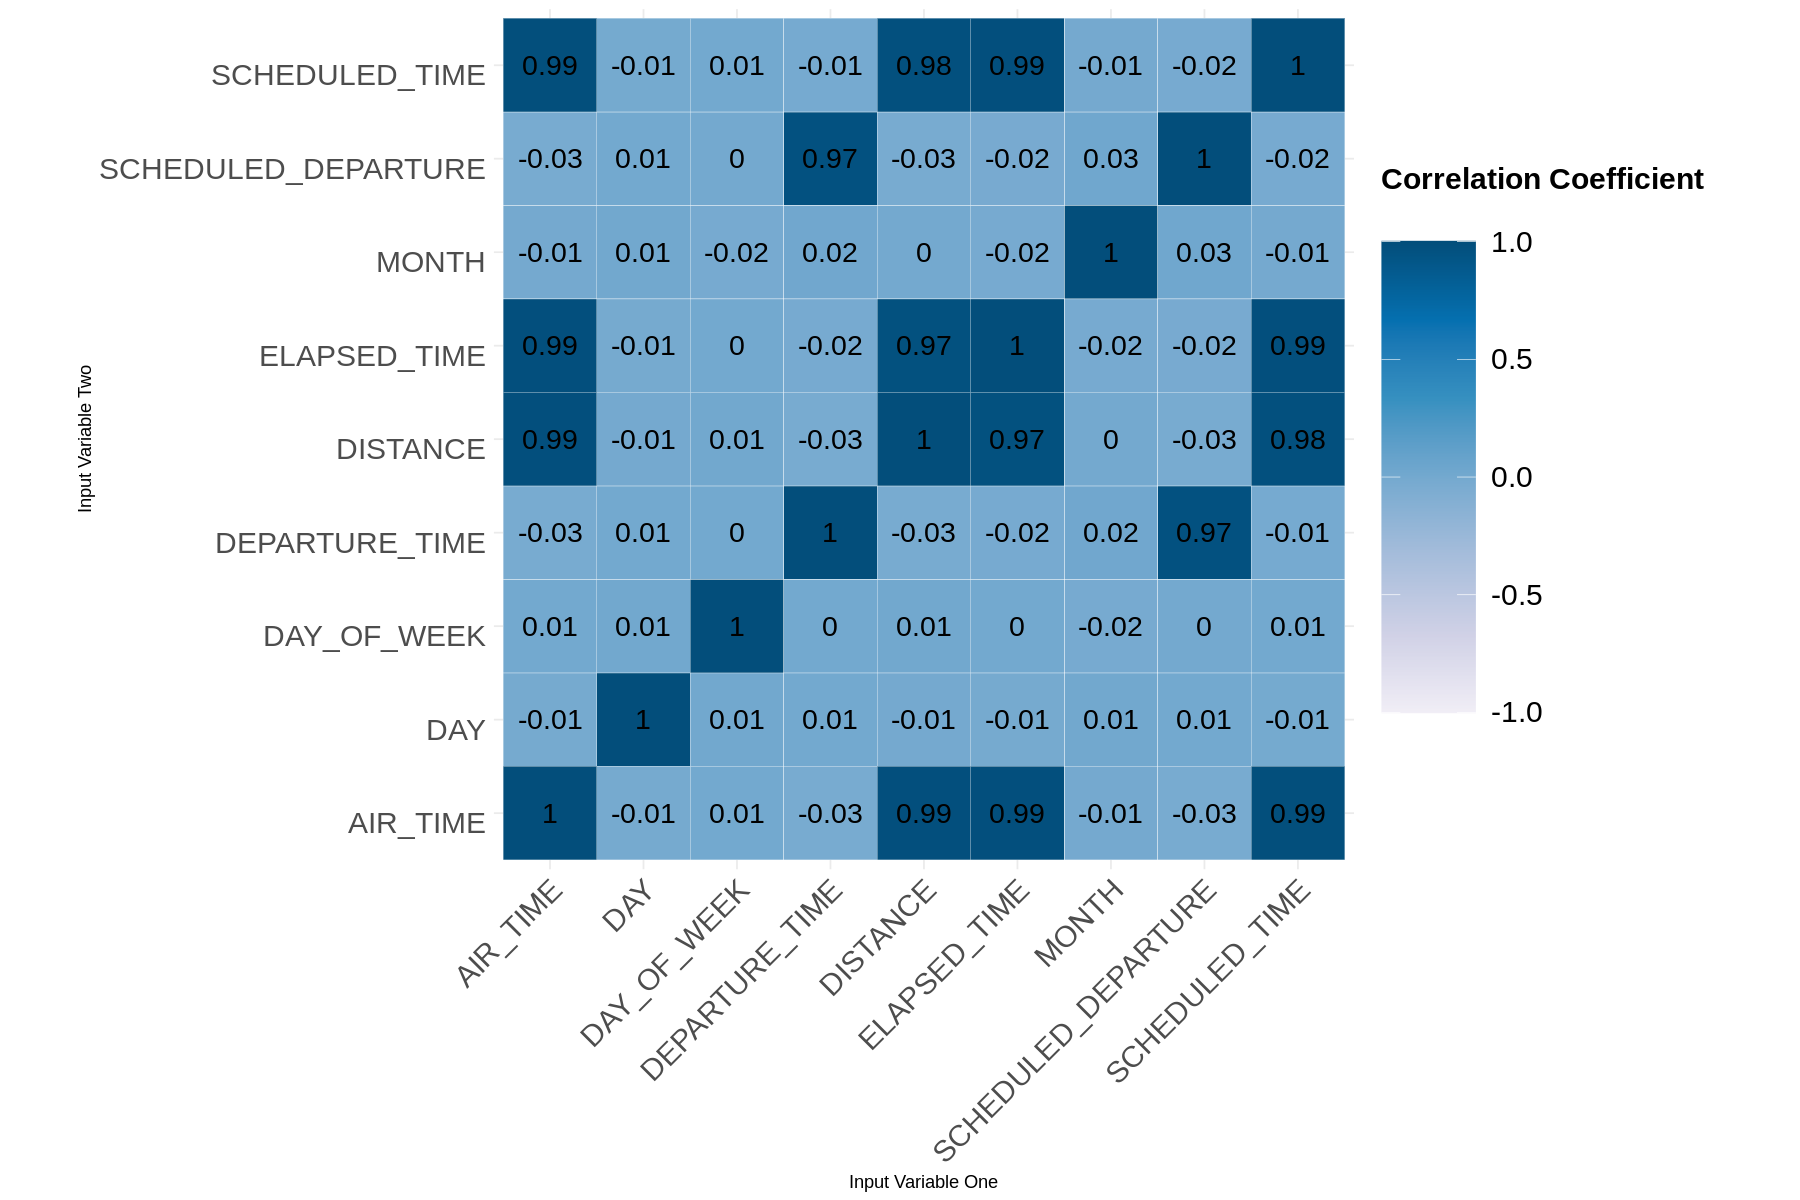

In [6]:
options(repr.plot.width = 15, repr.plot.height = 10)
corr_matrix_flight_plot <- corr_matrix_flight %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette =  "PuBu",
    direction = 1, limits = c(-1,1)
  ) +
  labs(x = "Input Variable One", y = "Input Variable Two") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 18, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 18, hjust = 1
    ),
    legend.title = element_text(size = 18, face = "bold"),
    legend.text = element_text(size = 18),
    legend.key.size = unit(2, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 6)
corr_matrix_flight_plot

* There are several strong positive correlations in the graph which suggests multicollinearity among explanatory variables.

### Summary Table

* We applied gather() to convert the dataset into a long format, then used summarise() to obtain summary statistic for all interested variables.

In [7]:
flight_data_long <- flight_data %>%
  select(-ORIGIN_AIRPORT,-DESTINATION_AIRPORT) %>%
  gather(factor_key=TRUE)
flight_data_stats <- flight_data_long %>% group_by(key) %>%
  summarise(mean= mean(value), sd= sd(value), max = max(value),min = min(value))
flight_data_stats

key,mean,sd,max,min
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
MONTH,6.617771,3.352518,12,1
DAY,15.643386,8.766960,31,1
DAY_OF_WEEK,3.911547,1.997542,7,1
SCHEDULED_DEPARTURE,1352.474885,489.287661,2359,5
DEPARTURE_TIME,1354.181509,499.597830,2400,3
DEPARTURE_DELAY,7.293976,34.964328,921,-24
SCHEDULED_TIME,147.987192,74.202873,585,43
ELAPSED_TIME,140.667400,73.512602,567,36
AIR_TIME,115.853112,71.241288,528,19


## 3. Methods

We are predicting average flight delays for Delta’s airline in 2015. In this report, we began by loading our dataset from Kaggle, and tidying the data in order to select the variables and columns that we are investigating. For initial visualizations, we began by checking the correlation of variables to delay time, as that is the variable we are trying to predict. We were able to make a correlation matrix plot that shows us that some of the variables are highly correlated. We believe that this report is trustworthy because we have collected true data from a very large data set. From a sample of over 800,000 individual samples, we took a random sample of 5,000 to make sure we do not have a biased sample. We also believe that since there is so much data, we can generate an accurate model that will allow us to have accurate predictions on delay time in flights.

We plan on making a generative model to determine flight delay time, as well as confidence intervals to determine how accurate our model is. We will be splitting our data set into test and training data, and then using a forward stepwise selection process to determine the most accurate model we can make.

We hope to achieve an accurate model that predicts flight delays correctly. This way we can make true evaluations on flights with delta and how likely your flight is to be delayed. This leads to a big impact on everyone because everyone can use this data in their own lives. If we find that one airport location is a lot more likely to be delayed with delta, you may be more cautious and avoid flying there for a layover. You can use these calculations to compare with other airline companies and figure out which airline is the most reliable and has the least flight delays. Overall, this analysis is very applicable because everyone flies and would love to know if their flight is going to be delayed.

## 4. References

Air Transport Action Group (2022). Social and economic benefits of Aviation. (n.d.). https://www.atag.org/our-activities/social-and-economic-benefits-of-aviation.html 

Trefis Team (2016), What Is The Impact Of Flight Delays? https://www.trefis.com/stock/dal/articles/375013/what-is-the-impact-of-flight-delays/2016-08-31

U.S. Department of Transportation (2017, February 9). 2015 flight delays and cancellations. Kaggle. Retrieved November 4, 2022, from https://www.kaggle.com/datasets/usdot/flight-delays 

Wang, Y., Zhu, J., & Liu, C. (2019). The analysis of the influence of delay absorbing sequence on flight delay propagation. IOP Conference Series: Materials Science and Engineering, 688(2), 022006. https://doi.org/10.1088/1757-899x/688/2/022006 

Wikipedia (2022). Delta Air Lines. https://en.wikipedia.org/wiki/Delta_Air_Lines
